# Random Forest - Fraud Check

### Problem Statement:
Use Random Forest to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

#### Input variables:

+ Undergrad : person is under graduated or not
+ Marital.Status : marital status of a person
+ Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government 
+ Work Experience : Work experience of an individual person
+ Urban : Whether that person belongs to urban area or not

### Step-1 : Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings as warnings
warnings.filterwarnings("ignore")
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import plot_tree
from collections import Counter
from sklearn import metrics
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

### Step-2 : Descriptive analysis

### Step-2.1 : Working with Dataset

#### Loading the Dataset

In [2]:
# Importing the dataset
fraud_data = pd.read_csv("Fraud_check.csv")

#### Exploring the dataset

In [3]:
# Displaying first ten records
fraud_data.head(10)

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
5,NO,Divorced,33329,116382,0,NO
6,NO,Divorced,83357,80890,8,YES
7,YES,Single,62774,131253,3,YES
8,NO,Single,83519,102481,12,YES
9,YES,Divorced,98152,155482,4,YES


In [4]:
# Shape of the data
fraud_data.shape

(600, 6)

In [5]:
# Summary of the data
fraud_data.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [6]:
# Check the data types
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


#### Modifying the dataset

In [7]:
fraud_data = fraud_data.rename(columns={"Undergrad":"Under_grad","Marital.Status":"Marital","Taxable.Income":"Tax_income","City.Population":"City_pop","Work.Experience":"Work_exp"})
fraud_data

,Under_grad,Marital,Tax_income,City_pop,Work_exp,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


### Step-2.2 : Handling missing values

In [8]:
# Check for Null values
fraud_data.isnull().sum()

Under_grad    0
Marital       0
Tax_income    0
City_pop      0
Work_exp      0
Urban         0
dtype: int64

In [9]:
# Check for duplicate values
fraud_data[fraud_data.duplicated()].shape

(0, 6)

In [10]:
fraud_data[fraud_data.duplicated()]

,Under_grad,Marital,Tax_income,City_pop,Work_exp,Urban


### Step-2.3 : Feature Engineering

In [11]:
fraud_data.Tax_income.describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Tax_income, dtype: float64

####  Let us  assume  that  taxable income <= 30000 as “Risky=0” and others are “Good=1”

In [12]:
# Including a column "Tax_income_cat" which is the Taxable income category dividing the Taxable income into three categories
fraud_data['Tax_income_cat'] = pd.cut(x = fraud_data['Tax_income'], bins = [10002,30000,99620], labels=['Risky','Good'], right = False)
fraud_data.head()

,Under_grad,Marital,Tax_income,City_pop,Work_exp,Urban,Tax_income_cat
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


In [13]:
fraud_data.Tax_income_cat.value_counts()

Good     476
Risky    124
Name: Tax_income_cat, dtype: int64

### Step-2.4 : Exploring data using Visualisation

#### Differentiate Categorical and Numerical features

In [14]:
fraud_data_cat = fraud_data.select_dtypes(include=['object','category'])
fraud_data_cat

,Under_grad,Marital,Urban,Tax_income_cat
0,NO,Single,YES,Good
1,YES,Divorced,YES,Good
2,NO,Married,YES,Good
3,YES,Single,YES,Good
4,NO,Married,NO,Good
...,...,...,...,...
595,YES,Divorced,YES,Good
596,YES,Divorced,YES,Good
597,NO,Divorced,YES,Good
598,YES,Married,NO,Good


In [15]:
fraud_data_num = fraud_data.select_dtypes(include=['int64'])
fraud_data_num

,Tax_income,City_pop,Work_exp
0,68833,50047,10
1,33700,134075,18
2,36925,160205,30
3,50190,193264,15
4,81002,27533,28
...,...,...,...
595,76340,39492,7
596,69967,55369,2
597,47334,154058,0
598,98592,180083,17


#### Differentiate Discrete and Continuous features
+ Numerical variables are usually of 2 types 
+ Discrete features and continuous features

In [16]:
discrete_feature=[feature for feature in fraud_data_num.columns if len(fraud_data[feature].unique())<10]
discrete_feature

[]

In [17]:
continuous_feature=[feature for feature in fraud_data_num.columns if feature not in discrete_feature]
continuous_feature

['Tax_income', 'City_pop', 'Work_exp']

In [18]:
fraud_data_cont = fraud_data_num[continuous_feature]
fraud_data_cont

,Tax_income,City_pop,Work_exp
0,68833,50047,10
1,33700,134075,18
2,36925,160205,30
3,50190,193264,15
4,81002,27533,28
...,...,...,...
595,76340,39492,7
596,69967,55369,2
597,47334,154058,0
598,98592,180083,17


#### Univariate Analysis

#### Histogram

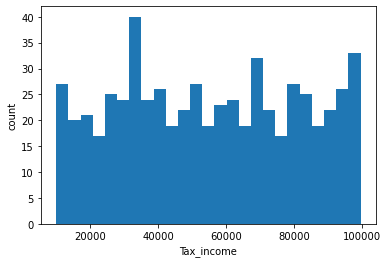

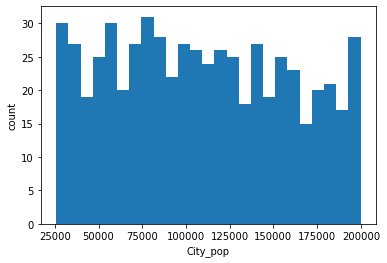

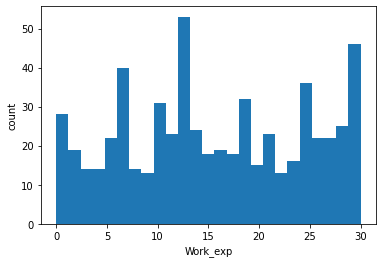

In [19]:
for feature in fraud_data_cont.columns:
    plt.figure()
    plt.hist(fraud_data_cont[feature],bins=25)
    plt.xlabel(feature)
    plt.ylabel("count")

#### Boxplot

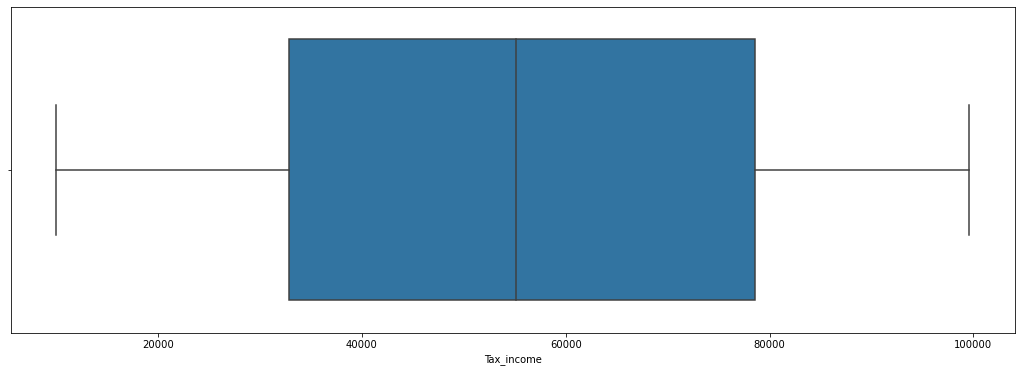

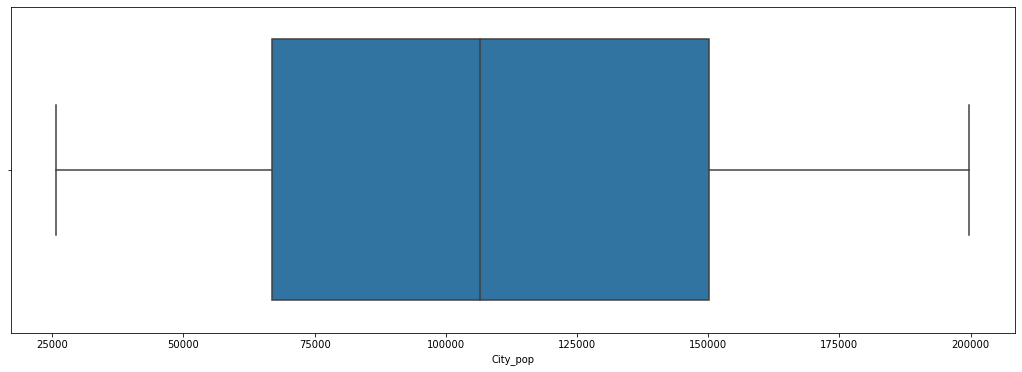

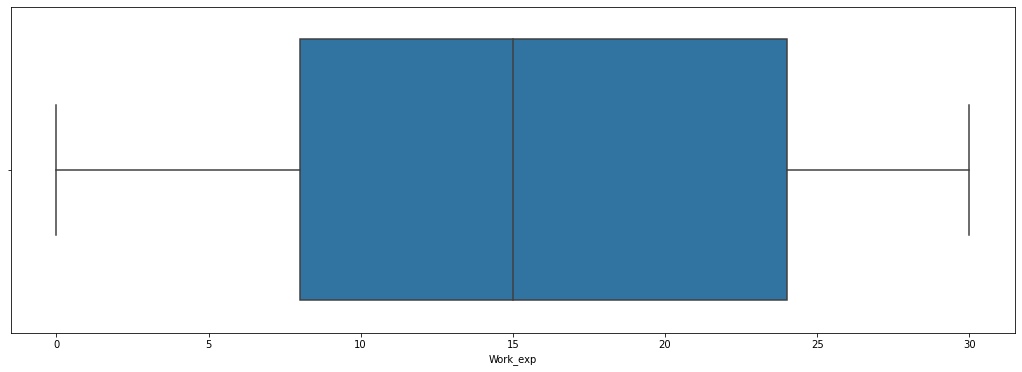

In [20]:
for feature in fraud_data_cont.columns:
    plt.figure(figsize=(18,6))
    sb.boxplot(fraud_data_cont[feature])

<AxesSubplot:>

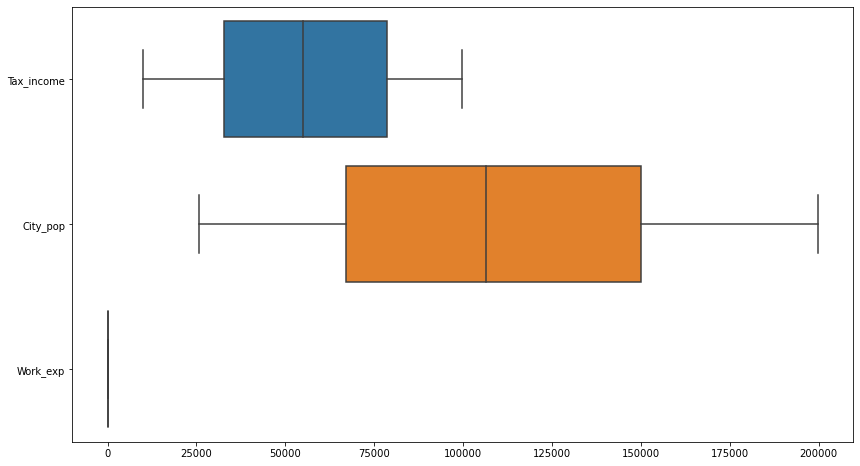

In [21]:
plt.figure(figsize=(14,8))
sb.boxplot(data=fraud_data_num, orient='h')

#### Multivariate Analysis

#### Correlation and Heat map

In [22]:
# Checking for Correlation between variables
fraud_data_cont.corr()

,Tax_income,City_pop,Work_exp
Tax_income,1.000000,-0.064387,-0.001818
City_pop,-0.064387,1.000000,0.013135
Work_exp,-0.001818,0.013135,1.000000


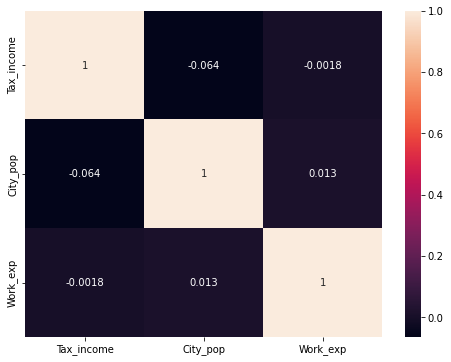

In [23]:
plt.figure(figsize=(8,6))
sb.heatmap(fraud_data_cont.corr(),annot=True)
plt.show()

<Figure size 576x576 with 0 Axes>

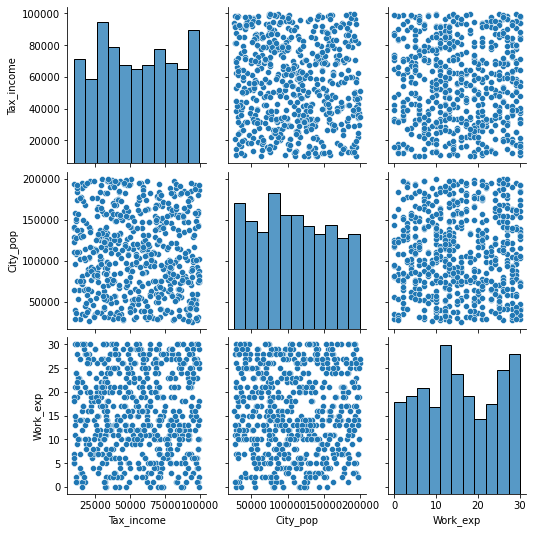

In [24]:
plt.figure(figsize=(8,8))
sb.pairplot(fraud_data, palette='coolwarm')
plt.show()

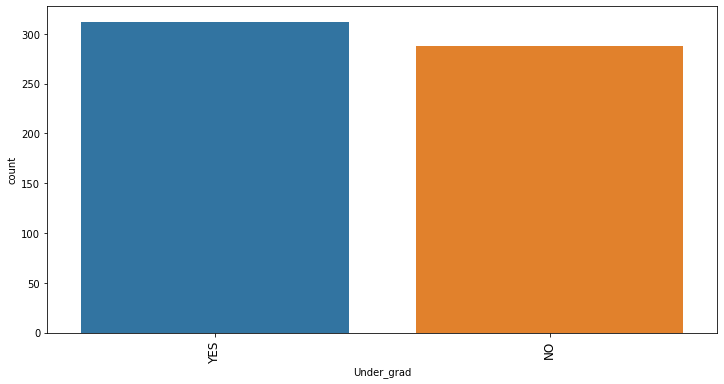

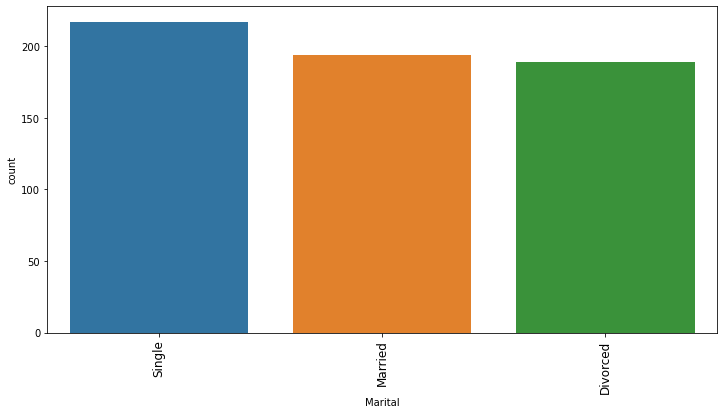

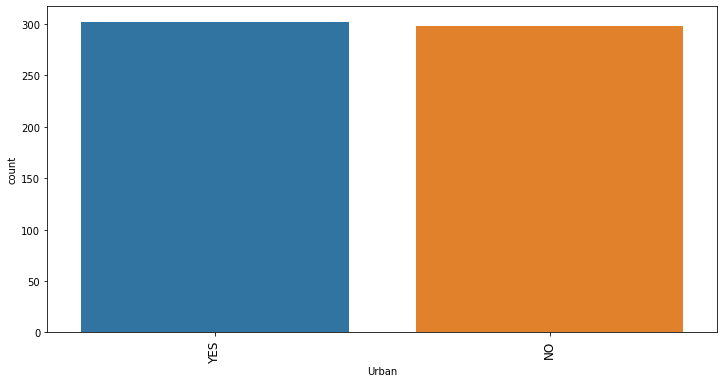

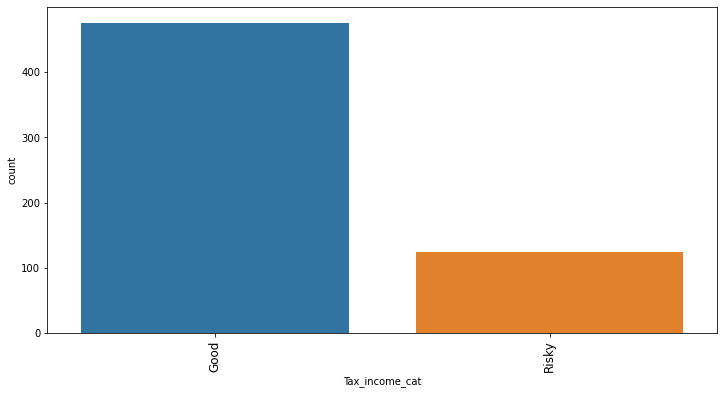

In [25]:
for i in fraud_data_cat.columns:
    plt.figure(figsize=(12,6))
    sb.countplot(x=i, data=fraud_data_cat, 
              order=fraud_data_cat[i].value_counts().index)
    plt.xticks(rotation = 90,fontsize = 12)
plt.show()

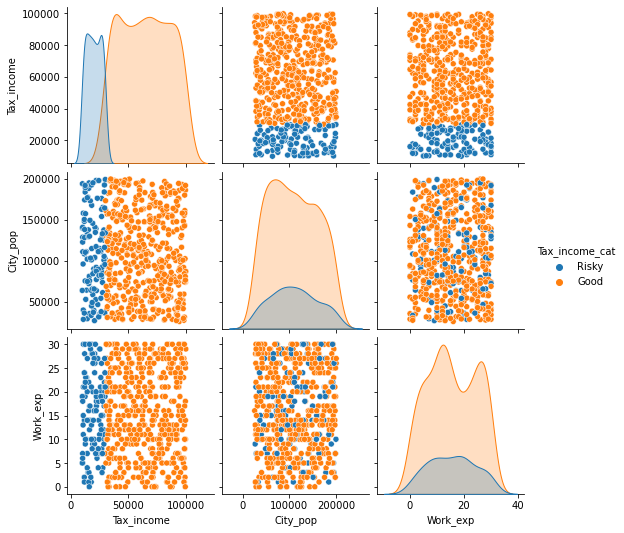

In [26]:
sb.pairplot(data=fraud_data, hue = 'Tax_income_cat')

<Figure size 864x432 with 0 Axes>

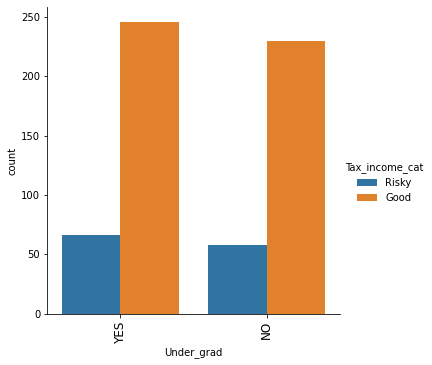

<Figure size 864x432 with 0 Axes>

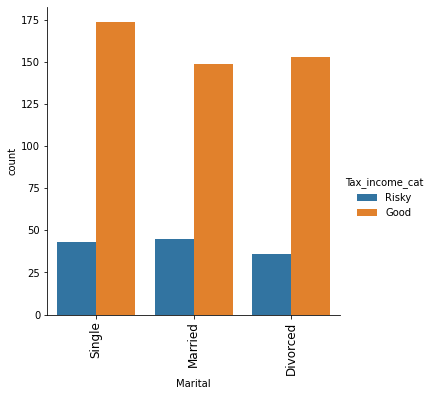

<Figure size 864x432 with 0 Axes>

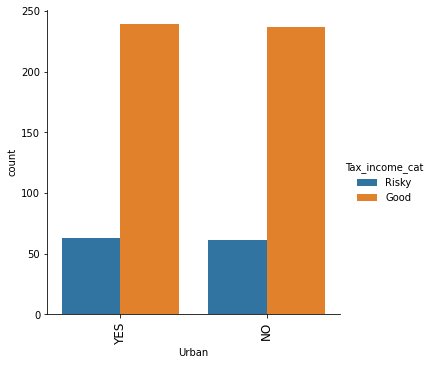

<Figure size 864x432 with 0 Axes>

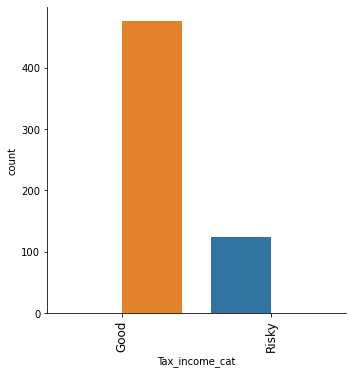

In [27]:
for i in fraud_data_cat.columns:
    plt.figure(figsize=(12,6))
    sb.catplot(data=fraud_data_cat,x=i,hue="Tax_income_cat",kind='count',
              order=fraud_data_cat[i].value_counts().index)
    plt.xticks(rotation = 90,fontsize = 12)
plt.show()

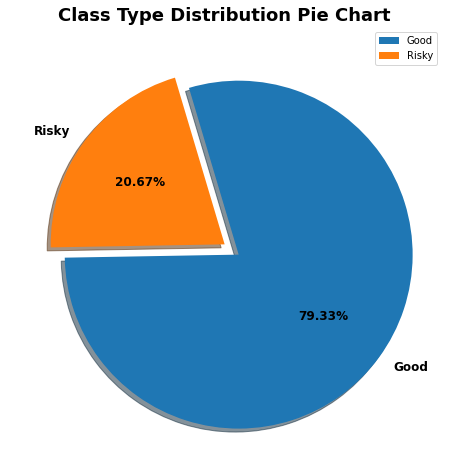

In [28]:
plt.figure(figsize = (12,8))
plt.pie(fraud_data['Tax_income_cat'].value_counts(),
       labels=fraud_data.Tax_income_cat.unique(),
       explode = [0.1,0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 181,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

### Step-3 : Data Pre-Processing

#### Converting categorical variables into numerical using Label encoder

In [29]:
fraud_data_mdf = fraud_data.copy()
fraud_data_mdf.drop('Tax_income', axis=1, inplace = True)

In [30]:
le = LabelEncoder()
for col in fraud_data_cat.columns:
        le.fit(fraud_data_mdf[col])
        fraud_data_mdf[col] = le.transform(fraud_data_mdf[col])
fraud_data_mdf.head()

,Under_grad,Marital,City_pop,Work_exp,Urban,Tax_income_cat
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


### Step-4 : Feature Selection

### Step-4.1 : Split the data into training and testing data

In [31]:
x = fraud_data_mdf.drop('Tax_income_cat', 1)
y = fraud_data_mdf['Tax_income_cat']

In [32]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)

classifier_rf.fit(x, y)

# checking the oob score
print('checking the oob score',classifier_rf.oob_score_)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}
from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(x, y)

print('Best Score',grid_search.best_score_)

rf_best = grid_search.best_estimator_
print(rf_best)

checking the oob score 0.7933333333333333
Fitting 4 folds for each of 180 candidates, totalling 720 fits
Best Score 0.7933333333333333
RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


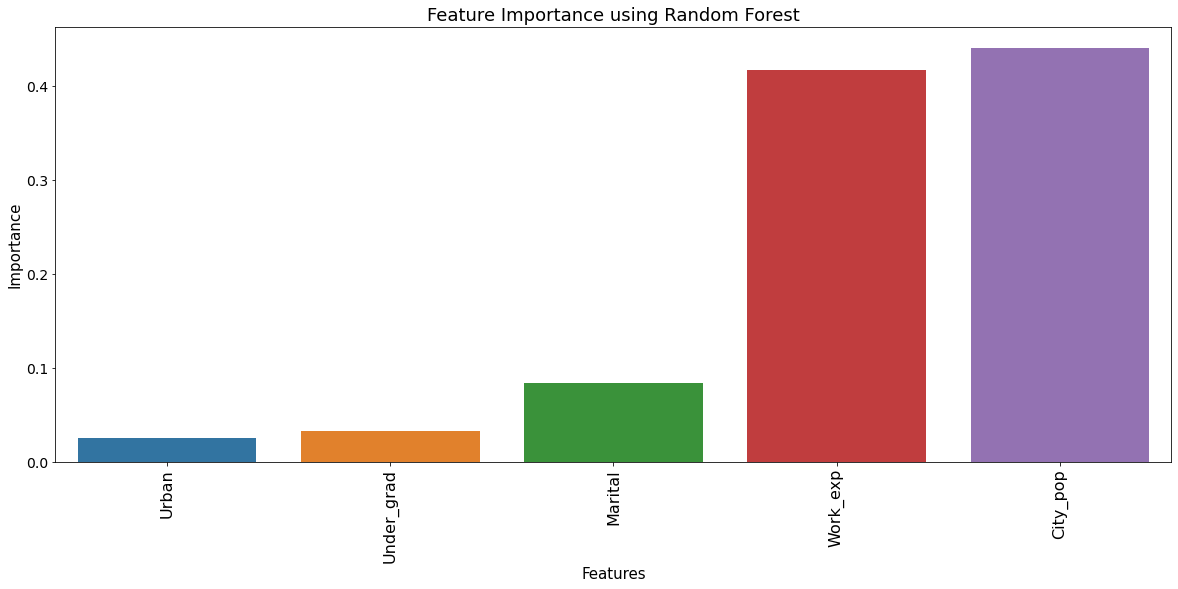

In [33]:
rf_best.feature_importances_
imp_df = pd.DataFrame({
    "Feature": x.columns,
    "Importance": rf_best.feature_importances_
})

plt.figure(figsize=(20,8))
# make barplot and sort bars
sb.barplot(x='Feature',
            y="Importance", 
            data=imp_df, 
            order=imp_df.sort_values('Importance').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Importance using Random Forest", size=18)
plt.show()

In [34]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 429, 1: 111}) Testing Data Counter({0: 47, 1: 13})


In [35]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,random_state=42)

In [36]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


### Step-5 : Build a Random Forest model

### Step-5.1 : Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [37]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [38]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(train_X, train_y)

print_score(rf_clf, train_X, train_y, test_X, test_y, train=True)
print_score(rf_clf, train_X, train_y, test_X, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    429.0  111.0       1.0      540.0         540.0
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [  0 111]]

Test Result:
Accuracy Score: 80.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.796610   1.000000       0.8   0.898305      0.840678
recall      1.000000   0.076923       0.8   0.538462      0.800000
f1-score    0.886792   0.142857       0.8   0.514825      0.725606
support    47.000000  13.000000       0.8  60.000000     60.000000
_______________________________________________
Confusion Matr

### Step-5.2 : Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [39]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    333.0  87.0       1.0      420.0         420.0
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [  0  87]]

Test Result:
Accuracy Score: 74.44%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.783626   0.0  0.744444    0.391813      0.622547
recall       0.937063   0.0  0.744444    0.468531      0.744444
f1-score     0.853503   0.0  0.744444    0.426752      0.678061
support    143.000000  37.0  0.744444  180.000000    180.000000
_______________________________________________
Confusion Matrix: 
 [[134   9]
 [ 

#### Observation: 
+ In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

### Step-6 : Handling imbalance data using SMOTE based techniques

In [40]:
x = fraud_data_mdf.drop(['Tax_income_cat'], axis=1)
y = fraud_data_mdf['Tax_income_cat']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=42,stratify=y)

In [41]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


### Step-6.1 : SMOTE Oversampling technique

In [42]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


### Step-6.2 : ADASYN: Adaptive Synthetic Sampling Approach

In [43]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=42)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 323})


### Step-6.3 : Hybridization: SMOTE + Tomek Links

In [44]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=42)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 255, 1: 255})


### Step-6.4 : Hybridization: SMOTE + ENN

In [45]:
counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({1: 100, 0: 95})


### Step-6.5 : Performance Analysis after Resampling

In [46]:
sampled_data = {
    'ACTUAL':[x_train, y_train],
    'SMOTE':[x_train_sm, y_train_sm],
    'ADASYN':[x_train_ada, y_train_ada],
    'SMOTE_TOMEK':[x_train_smtom, y_train_smtom],
    'SMOTE_ENN':[x_train_smenn, y_train_smenn]
}

In [47]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    #plot_confusion_matrix(clf_model, X_test, y_test)  
    #plt.show() 
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    #print('AUC-ROC')
    #print('='*60)
    #print(roc_auc_score(y_test, y_prob[:,1], multi_class='ovo'))
    
    #x = roc_auc_score(y_test, y_prob[:,1])
    f1 = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    
    return algo,precision,recall,f1,sampling

In [48]:
model_params = {

    'random-forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
             "n_estimators": [5, 10, 15, 20, 25], 
             'max_depth': [i for i in range(5,16,2)],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ['log2', 'sqrt', 'auto']

         }
    }
}

In [49]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resam , data in sampled_data.items():
        clf = RandomizedSearchCV(model_hp['model'], model_hp['params'],cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf.fit(data[0], data[1])
        clf_best = clf.best_estimator_
        print('x'*60)
        print(model+' with ' + resam)
        print('='*60)
        output.append(test_eval(clf_best, x_test, y_test, model, resam))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with ACTUAL
Confusion Matrix
[[143   0]
 [ 37   0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with SMOTE
Confusion Matrix
[[89 54]
 [24 13]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.62      0.70       143
           1       0.19      0.35      0.25        37

    accuracy                           0.57       180
   macro avg       0.49      0.49      0.47       180
weighted avg       0.67      0.57      0.60       180
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

#### As per the above results, we can observe that ADASYN technique gave the best results. Hence use this.

In [50]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 323})


In [51]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter = Counter(y_train)
print('Train',counter)
counter = Counter(y_test)
print('Test',counter)
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Train Counter({0: 233, 1: 226})
Test Counter({0: 100, 1: 97})
Shape of X_train:  (459, 5)
Shape of X_test:  (197, 5)
Shape of y_train:  (459,)
Shape of y_test (197,)


### Step-7 : Random Forest

 ### Step-7.1 : Random Forest hyperparameter tuning

In [52]:
#base model
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [53]:
loc = np.array(score_array).max()
score_array.index(loc)+1

20

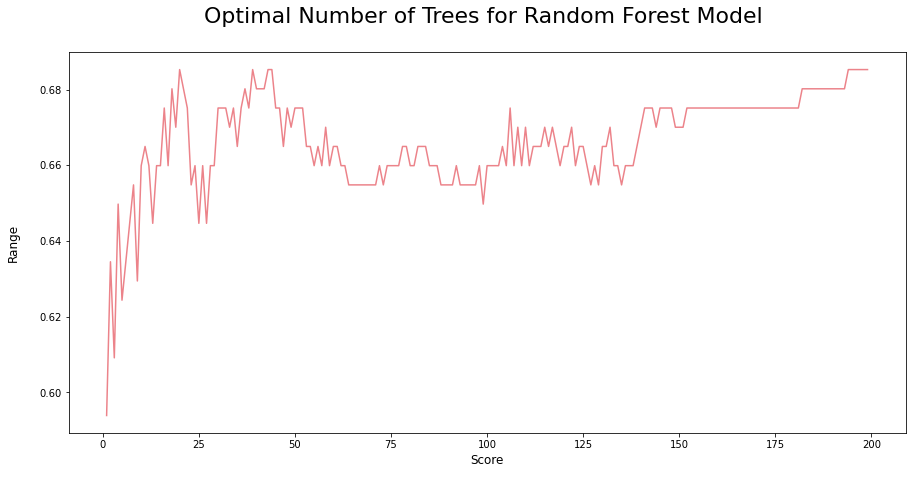

In [54]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

#### a) Randomized Search Cross Validation<a class="anchor" id="a"></a> 

In [55]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 90, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True})
Train Result:
Accuracy Score: 96.51%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.961702    0.968750  0.965142    0.965226      0.965172
recall       0.969957    0.960177  0.965142    0.965067      0.965142
f1-score     0.965812    0.964444  0.965142    0.965128      0.965139
support    233.000000  226.000000  0.965142  459.000000    459.000000
_______________________________________________
Confusion Matrix: 
 [[226   7]
 [  9 217]]

Test Result:
Accuracy Score: 66.50%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.693182   0.642202  0.664975    0.667692      0.6680

#### `Random search` allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with `GridSearchCV`, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define

#### b) Grid Search Cross Validation<a class="anchor" id="b"></a> 

In [56]:
# Create a pipeline with a Random forest classifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from time import time
    
pipe_rfc = Pipeline([ 
                      ('scl', StandardScaler()), 
                    ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])

# Set the grid parameters
param_grid_rfc =  [ {
    'rfc__n_estimators': [100, 200,300,400], # number of estimators
    #'rfc__criterion': ['gini', 'entropy'],   # Splitting criterion
    'rfc__max_features':[0.05 , 0.1], # maximum features used at each split
    'rfc__max_depth': [None, 5], # Max depth of the trees
    'rfc__min_samples_split': [0.005, 0.01], # mininal samples in leafs
    }]
# Use 10 fold CV
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

#Fit the pipeline
start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))

# Best score and best parameters
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 82.191 seconds
-------Best score----------
73.54229963935136
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 300}


 ### Step-7.1 : Visualizing one of the decision tree in random forest

In [57]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, max_features='auto', min_samples_split=5,
                       n_estimators=90, random_state=42)

In [58]:
fraud_data.Tax_income_cat.unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

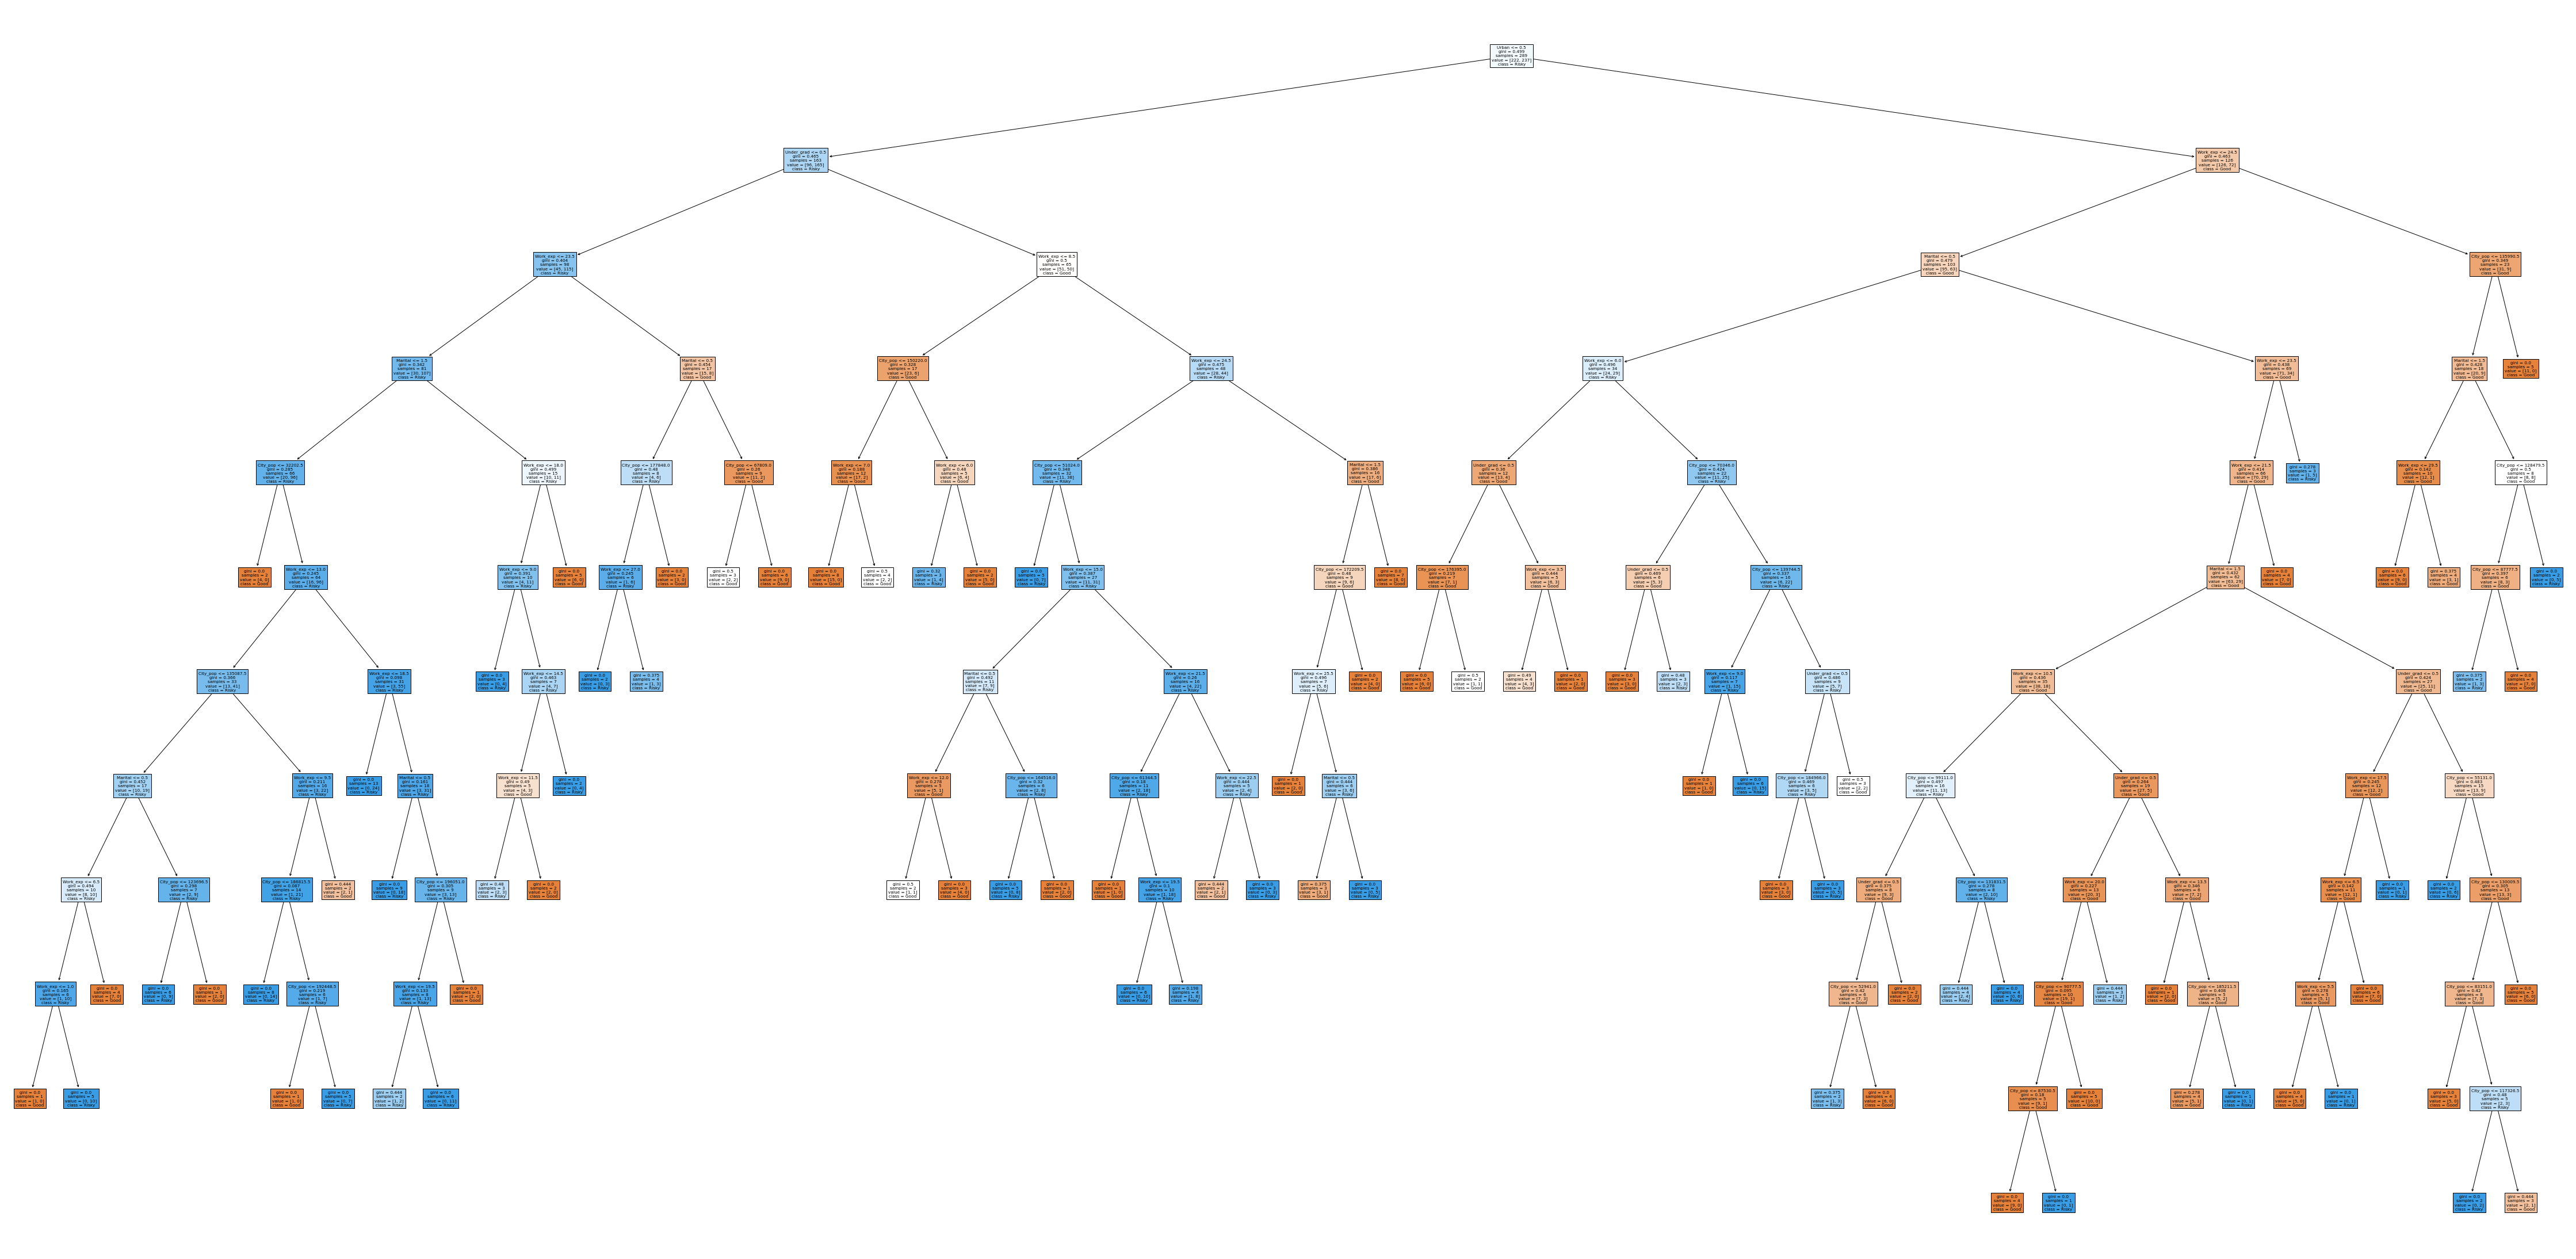

In [59]:
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[59], feature_names = fraud_data_mdf.columns,class_names=fraud_data.Tax_income_cat.unique(),filled=True)
plt.show()